In [ ]:
import pandas as pd 
import numpy as np 
# Load AIS data 
ais_data = pd.read_csv("ais_dataset.csv")  # Replace with actual file path 
# Load each emission factor file 
propulsion_factors = pd.read_csv("propulsion_engine_emission_factors.csv") 
boiler_factors = pd.read_csv("boiler_engine_emission_factors.csv") 
auxiliary_factors = pd.read_csv("auxiliary_engine_emission_factors.csv") 
# Add a column to identify engine type 
propulsion_factors["engine_type"] = "propulsion" 
boiler_factors["engine_type"] = "boiler" 
auxiliary_factors["engine_type"] = "auxiliary" 
# Combine all emission factor files into one DataFrame 
emission_factors = pd.concat([propulsion_factors, boiler_factors, auxiliary_factors], ignore_index=True) 
# Display the combined data 
print(emission_factors.head()) 
# Step 1: Merge AIS data with emission factors based on vessel type or ID 
merged_data = ais_data.merge(emission_factors, on="vessel_type")  # Adjust 'vessel_type' as per your dataset 
# Step 2: Calculate total time in anchorage (hours) 
merged_data["anchorage_time_hours"] = (pd.to_datetime(merged_data["departure_time"]) -  
                                       pd.to_datetime(merged_data["arrival_time"])).dt.total_seconds() / 3600 
# Step 3: Calculate emissions for each vessel 
merged_data["emission_before_jit"] = (merged_data["fuel_consumption_rate"] *  
                                      merged_data["anchorage_time_hours"] *  
                                      merged_data["emission_factor"]) 
# Step 4: Aggregate emissions 
anc_before_jit = merged_data["emission_before_jit"].sum() 
print(f"Total CO2 emissions before JIT: {anc_before_jit} tonnes")


                                  fuel  fuel_category sulfur engine_type  \
0  HFO (outside ECA and prior to 2020)              1  2.70%  propulsion   
1  HFO (outside ECA and prior to 2020)              1  2.70%  propulsion   
2  HFO (outside ECA and prior to 2020)              1  2.70%  propulsion   
3  HFO (outside ECA and prior to 2020)              1  2.70%  propulsion   
4  HFO (outside ECA and prior to 2020)              1  2.70%  propulsion   

   emission_tier model_years   nox  pm10  pm2_5    voc     sox   n2_O   ch4  \
0            0.0    Pre-2000  18.1  1.42   1.31  0.632  10.293  0.031  0.01   
1            1.0   2000-2010  17.0  1.42   1.31  0.632  10.293  0.031  0.01   
2            2.0   post 2010  15.3  1.42   1.31  0.632  10.293  0.031  0.01   
3            0.0    Pre-2000  14.0  1.43   1.32  0.530  11.244  0.030  0.01   
4            1.0   2000-2010  13.0  1.43   1.32  0.530  11.244  0.030  0.01   

    sfoc  n_ox  bsfc engine_size  s_ox  n2_o  
0  195.0   NaN   NaN 

KeyError: 'vessel_type'

In [28]:
import pandas as pd

# Load datasets
ais_data = pd.read_csv('ais_dataset.csv')
aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')

# Filter engine factors for matching fuel_category
aux_engine_factors = aux_engine_factors[aux_engine_factors['fuel_category'] == 2]
boiler_engine_factors = boiler_engine_factors[boiler_engine_factors['fuel_category'] == 2]

# Step 1: Filter for anchorage events
anchorage_data = ais_data[(ais_data['speed'] < 1) & (ais_data['anchorage'] == 1)].copy()

# Step 2: Convert 'timestamp' to datetime and drop invalid rows
anchorage_data['timestamp'] = pd.to_datetime(anchorage_data['timestamp'], errors='coerce')
anchorage_data.dropna(subset=['timestamp'], inplace=True)

# Filter for July
july_data = anchorage_data[anchorage_data['timestamp'].dt.month == 7]

# Step 3: Merge datasets on 'fuel_category'
print("Before merge:", july_data.shape)
aux_merged = pd.merge(july_data, aux_engine_factors, on='fuel_category', how='left')
print("After auxiliary merge:", aux_merged.shape)
boiler_merged = pd.merge(aux_merged, boiler_engine_factors, on='fuel_category', how='left')
print("After boiler merge:", boiler_merged.shape)

# Step 4: Calculate emissions
boiler_merged['activity_duration_hours'] = (
    boiler_merged['timestamp'].diff().dt.total_seconds() / 3600
)
boiler_merged['aux_emissions'] = (
    boiler_merged['ael'] * boiler_merged['activity_duration_hours'] * boiler_merged['bsfc_x']
)
boiler_merged['boiler_emissions'] = (
    boiler_merged['abl'] * boiler_merged['activity_duration_hours'] * boiler_merged['bsfc_y']
)
boiler_merged['total_emissions'] = (
    boiler_merged['aux_emissions'] + boiler_merged['boiler_emissions']
)

# Step 5: Aggregate emissions for July
july_emissions = boiler_merged.groupby('imo')['total_emissions'].sum().reset_index()
july_emissions.columns = ['imo', 'anc_before_jit']
july_emissions['anc_before_jit'] /= 1000  # Convert grams to tonnes

# Save the results
print(july_emissions)
july_emissions.to_csv('anc_before_jit.csv', index=False)


Before merge: (0, 30)
After auxiliary merge: (0, 43)
After boiler merge: (0, 53)
Empty DataFrame
Columns: [imo, anc_before_jit]
Index: []


In [10]:
print(ais_data.columns)


Index(['imo', 'mmsi', 'vessel_name', 'date_of_build', 'vessel_type', 'group',
       'timestamp', 'lon', 'lat', 'nav_stat', 'speed', 'course', 'heading',
       'fuel_category', 'main_engine_fuel_type', 'aux_engine_fuel_type',
       'engine_type', 'berth', 'port_name', 'anchorage', 'terminal',
       'maneuvering_zone', 'p', 'vref', 'sfc_me', 'sfc_ae', 'sfc_ab', 'ael',
       'abl', 'distance'],
      dtype='object')


In [18]:
print(ais_data['timestamp'].head())
print(ais_data['timestamp'].dtype)







0    2024-07-28T00:23:32.000Z
1    2024-07-28T00:25:02.000Z
2    2024-07-28T00:30:01.000Z
3    2024-07-28T00:32:51.000Z
4    2024-07-28T00:35:02.000Z
Name: timestamp, dtype: object
object


In [20]:
print("AIS Data Columns:", ais_data.columns)
print("Auxiliary Engine Factors Columns:", aux_engine_factors.columns)
print("Boiler Engine Factors Columns:", boiler_engine_factors.columns)


AIS Data Columns: Index(['imo', 'mmsi', 'vessel_name', 'date_of_build', 'vessel_type', 'group',
       'timestamp', 'lon', 'lat', 'nav_stat', 'speed', 'course', 'heading',
       'fuel_category', 'main_engine_fuel_type', 'aux_engine_fuel_type',
       'engine_type', 'berth', 'port_name', 'anchorage', 'terminal',
       'maneuvering_zone', 'p', 'vref', 'sfc_me', 'sfc_ae', 'sfc_ab', 'ael',
       'abl', 'distance'],
      dtype='object')
Auxiliary Engine Factors Columns: Index(['fuel', 'fuel_category', 'sulfur', 'engine_size', 'emission_tier',
       'model_years', 'nox', 'pm10', 'pm2_5', 'voc', 's_ox', 'n2_o', 'ch4',
       'bsfc'],
      dtype='object')
Boiler Engine Factors Columns: Index(['fuel', 'fuel_category', 'sulfur', 'n_ox', 'pm10', 'pm2_5', 'voc',
       'sox', 'n2_O', 'ch4', 'bsfc'],
      dtype='object')


In [23]:
print(ais_data['fuel_category'].unique())
print(aux_engine_factors['fuel_category'].unique())
print(boiler_engine_factors['fuel_category'].unique())


[2]
[1 2 3]
[1 2 3]


In [24]:
print("Before merge:", july_data.shape)
aux_merged = pd.merge(july_data, aux_engine_factors, on='fuel_category', how='left')
print("After auxiliary merge:", aux_merged.shape)
boiler_merged = pd.merge(aux_merged, boiler_engine_factors, on='fuel_category', how='left')
print("After boiler merge:", boiler_merged.shape)


Before merge: (0, 30)
After auxiliary merge: (0, 43)
After boiler merge: (0, 53)


In [31]:
print("Fuel categories in July data:", july_data['fuel_category'].unique())


Fuel categories in July data: []


In [32]:
anchorage_data = ais_data[ais_data['anchorage'].notnull()].copy()


In [35]:
july_data = anchorage_data[anchorage_data['timestamp'].dt.month == 7]


In [ ]:
anchorage_data = ais_data[ais_data['anchorage'].notnull()].copy()


In [38]:
import pandas as pd

# Load datasets
ais_data = pd.read_csv('ais_dataset.csv')
aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')

# Step 1: Filter for anchorage events
anchorage_data = ais_data[ais_data['anchorage'].str.contains('Anchorage Zone', na=False)].copy()
anchorage_data['timestamp'] = pd.to_datetime(anchorage_data['timestamp'], errors='coerce')
anchorage_data.dropna(subset=['timestamp'], inplace=True)

# Step 2: Filter for July
july_data = anchorage_data[anchorage_data['timestamp'].dt.month == 7]
print("Unique IMO in July data before merge:", july_data['imo'].nunique())

# Step 3: Ensure all relevant fuel categories are covered
relevant_fuel_categories = july_data['fuel_category'].unique()
aux_engine_factors = aux_engine_factors[aux_engine_factors['fuel_category'].isin(relevant_fuel_categories)]
boiler_engine_factors = boiler_engine_factors[boiler_engine_factors['fuel_category'].isin(relevant_fuel_categories)]

# Step 4: Perform outer merges to retain all rows
aux_merged = pd.merge(july_data, aux_engine_factors, on='fuel_category', how='outer')
print("Unique IMO after auxiliary merge:", aux_merged['imo'].nunique())

boiler_merged = pd.merge(aux_merged, boiler_engine_factors, on='fuel_category', how='outer')
print("Unique IMO after boiler merge:", boiler_merged['imo'].nunique())

# Step 5: Fill missing values with defaults
boiler_merged['activity_duration_hours'] = (
    boiler_merged['timestamp'].diff().dt.total_seconds() / 3600
).fillna(0)
boiler_merged['ael'] = boiler_merged['ael'].fillna(0)
boiler_merged['abl'] = boiler_merged['abl'].fillna(0)
boiler_merged['bsfc_x'] = boiler_merged['bsfc_x'].fillna(0)
boiler_merged['bsfc_y'] = boiler_merged['bsfc_y'].fillna(0)

# Auxiliary engine emissions: E = L_A * A * EF
boiler_merged['aux_emissions'] = (
    boiler_merged['ael'] * boiler_merged['activity_duration_hours'] * boiler_merged['bsfc_x']
)

# Boiler emissions: E = L_B * A * EF
boiler_merged['boiler_emissions'] = (
    boiler_merged['abl'] * boiler_merged['activity_duration_hours'] * boiler_merged['bsfc_y']
)

# Total emissions at anchorage
boiler_merged['total_emissions'] = (
    boiler_merged['aux_emissions'] + boiler_merged['boiler_emissions']
)

# Step 6: Aggregate emissions for July
july_emissions = boiler_merged.groupby('imo')['total_emissions'].sum().reset_index()
july_emissions.columns = ['imo', 'anc_before_jit']
july_emissions['anc_before_jit'] /= 1000  # Convert grams to tonnes

# Fill missing IMOs with placeholders (if any)
july_emissions['imo'] = july_emissions['imo'].fillna('Unknown')

# Save results
print("Final emissions data:")
print(july_emissions.head())
july_emissions.to_csv('anc_before_jit_uncleansed.csv', index=False)


Unique IMO in July data before merge: 2337
Unique IMO after auxiliary merge: 2337
Unique IMO after boiler merge: 2337
Final emissions data:
       imo  anc_before_jit
0  1013315   -17009.030660
1  1014838    -6457.638222
2  1015820    24836.123125
3  1017775     6518.825733
4  1018547    99971.276731


In [39]:
print("Unique IMO in final output:", july_emissions['imo'].nunique())


Unique IMO in final output: 2337


In [47]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load AIS dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# Preprocess the dataset
def preprocess_data(data):
    # Convert timestamp to datetime format
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

    # Drop rows with missing or invalid values
    data.dropna(subset=['latitude', 'longitude', 'speed', 'vesselType'], inplace=True)

    return data.copy()

# Extract relevant features for clustering
def extract_features(data):
    # Select numerical features for clustering
    features = data[['latitude', 'longitude', 'speed']].copy()
    return features

# Perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)
    
    # Add cluster labels to the dataset
    features['cluster'] = clusters
    return features, kmeans

# Determine optimal number of clusters using the elbow method
def find_optimal_clusters(features, max_clusters=10):
    inertia = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        inertia.append(kmeans.inertia_)
    
    # Detect the elbow point
    kneedle = KneeLocator(range(1, max_clusters + 1), inertia, curve="convex", direction="decreasing")
    optimal_k = kneedle.knee

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f"Optimal Clusters: {optimal_k}")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Clusters')
    plt.legend()
    plt.show()

    return optimal_k

# Plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['longitude'], features['latitude'], c=features['cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='cluster')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('Vessel Clusters')
    plt.show()

# Main function to determine vessel groups
def main(file_path):
    # Step 1: Load data
    data = load_data(file_path)

    # Step 2: Preprocess data
    data = preprocess_data(data)

    # Step 3: Extract features for clustering
    features = extract_features(data)

    # Step 4: Determine the optimal number of clusters
    print("Determining optimal number of clusters...")
    optimal_k = find_optimal_clusters(features, max_clusters=10)
    print(f"Optimal number of clusters: {optimal_k}")

    # Step 5: Perform clustering
    print("Performing clustering...")
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=optimal_k)

    # Step 6: Merge clusters back into original data
    data['Cluster'] = clustered_features['Cluster']

    # Step 7: Visualize clusters
    plot_clusters(clustered_features)

    # Save clustered data to a CSV file
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("Clustered data saved to 'clustered_vessel_data.csv'")



In [45]:
def main(file_path):
    # Step 1: Load data
    data = load_data(file_path)

    # Step 2: Preprocess data
    data = preprocess_data(data)

    # Step 3: Extract features for clustering
    features = extract_features(data)

    # Step 4: Determine the optimal number of clusters
    print("Determining optimal number of clusters...")
    optimal_k = find_optimal_clusters(features, max_clusters=10)
    print(f"Optimal number of clusters: {optimal_k}")

    # Step 5: Perform clustering
    print("Performing clustering...")
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=optimal_k)

    # Step 6: Merge clusters back into original data
    data['Cluster'] = clustered_features['Cluster']

    # Step 7: Visualize clusters
    plot_clusters(clustered_features)

    # Save clustered data to a CSV file
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("Clustered data saved to 'clustered_vessel_data.csv'")


In [48]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load AIS dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# Preprocess the dataset
def preprocess_data(data):
    # Ensure consistent column names and clean data
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

    # Drop rows with missing or invalid values
    data.dropna(subset=['Latitude', 'Longitude', 'Speed', 'VesselType'], inplace=True)

    return data.copy()

# Extract relevant features for clustering
def extract_features(data):
    # Select numerical features for clustering
    features = data[['Latitude', 'Longitude', 'Speed']].copy()
    return features

# Perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # Add cluster labels to the dataset
    features['Cluster'] = clusters
    return features, kmeans

# Main function to return clustered DataFrame
def main(file_path):
    # Step 1: Load data
    data = load_data(file_path)

    # Step 2: Preprocess data
    data = preprocess_data(data)

    # Step 3: Extract features for clustering
    features = extract_features(data)

    # Step 4: Perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # Step 5: Add cluster labels back to original data
    data['Cluster'] = clustered_features['Cluster'].values

    # Step 6: Return the clustered DataFrame
    return data

# Run the function to get the clustered DataFrame
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# Save the clustered DataFrame to a CSV file
clustered_df.to_csv('clustered_vessel_data.csv', index=False)
print("Clustered DataFrame saved to 'clustered_vessel_data.csv'")

# Print a sample of the clustered DataFrame
print(clustered_df.head())


KeyError: 'Timestamp'

In [49]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load AIS dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# Preprocess the dataset
def preprocess_data(data):
    # Dynamically handle timestamp column
    timestamp_col = next((col for col in data.columns if 'timestamp' in col.lower()), None)
    if timestamp_col:
        data['Timestamp'] = pd.to_datetime(data[timestamp_col], errors='coerce')
    else:
        print("Warning: No timestamp column found. Creating a dummy timestamp column.")
        data['Timestamp'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(range(len(data)), unit='s')

    # Drop rows with missing or invalid values
    data.dropna(subset=['Latitude', 'Longitude', 'Speed', 'VesselType'], inplace=True)

    return data.copy()

# Extract relevant features for clustering
def extract_features(data):
    # Select numerical features for clustering
    features = data[['Latitude', 'Longitude', 'Speed']].copy()
    return features

# Perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # Add cluster labels to the dataset
    features['Cluster'] = clusters
    return features, kmeans

# Plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['Longitude'], features['Latitude'], c=features['Cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Cluster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Vessel Clusters')
    plt.show()

# Main function to return clustered DataFrame
def main(file_path):
    # Step 1: Load data
    data = load_data(file_path)

    # Step 2: Preprocess data
    data = preprocess_data(data)

    # Step 3: Extract features for clustering
    features = extract_features(data)

    # Step 4: Perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # Step 5: Add cluster labels back to original data
    data['Cluster'] = clustered_features['Cluster'].values

    # Step 6: Visualize clusters
    plot_clusters(clustered_features)

    # Step 7: Save and return the clustered DataFrame
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("Clustered DataFrame saved to 'clustered_vessel_data.csv'")

    return data

# Run the function to get the clustered DataFrame
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# Print a sample of the clustered DataFrame
print(clustered_df.head())


KeyError: ['Latitude', 'Longitude', 'Speed', 'VesselType']

In [50]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load AIS dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# Preprocess the dataset
def preprocess_data(data):
    # Dynamically handle timestamp column
    timestamp_col = next((col for col in data.columns if 'timestamp' in col.lower()), None)
    if timestamp_col:
        data['Timestamp'] = pd.to_datetime(data[timestamp_col], errors='coerce')
    else:
        print("Warning: No timestamp column found. Creating a dummy timestamp column.")
        data['Timestamp'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(range(len(data)), unit='s')

    # Check if required columns exist
    required_columns = ['Latitude', 'Longitude', 'Speed', 'VesselType']
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        raise KeyError(f"Missing required columns: {missing_columns}")

    # Drop rows with missing or invalid values
    data.dropna(subset=required_columns, inplace=True)

    return data.copy()

# Extract relevant features for clustering
def extract_features(data):
    # Select numerical features for clustering
    features = data[['Latitude', 'Longitude', 'Speed']].copy()
    return features

# Perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # Add cluster labels to the dataset
    features['Cluster'] = clusters
    return features, kmeans

# Plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['Longitude'], features['Latitude'], c=features['Cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Cluster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Vessel Clusters')
    plt.show()

# Main function to return clustered DataFrame
def main(file_path):
    # Step 1: Load data
    data = load_data(file_path)

    # Step 2: Preprocess data
    data = preprocess_data(data)

    # Step 3: Extract features for clustering
    features = extract_features(data)

    # Step 4: Perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # Step 5: Add cluster labels back to original data
    data['Cluster'] = clustered_features['Cluster'].values

    # Step 6: Visualize clusters
    plot_clusters(clustered_features)

    # Step 7: Save and return the clustered DataFrame
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("Clustered DataFrame saved to 'clustered_vessel_data.csv'")

    return data

# Run the function to get the clustered DataFrame
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# Print a sample of the clustered DataFrame
print(clustered_df.head())

KeyError: "Missing required columns: ['Latitude', 'Longitude', 'Speed', 'VesselType']"

In [51]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# load ais dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# preprocess the dataset
def preprocess_data(data):
    # dynamically handle timestamp column
    timestamp_col = next((col for col in data.columns if 'timestamp' in col.lower()), None)
    if timestamp_col:
        data['timestamp'] = pd.to_datetime(data[timestamp_col], errors='coerce')
    else:
        print("Warning: No timestamp column found. Creating a dummy timestamp column.")
        data['timestamp'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(range(len(data)), unit='s')

    # check if required columns exist
    required_columns = ['latitude', 'longitude', 'speed', 'vesseltype']
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        raise KeyError(f"Missing required columns: {missing_columns}")

    # drop rows with missing or invalid values
    data.dropna(subset=required_columns, inplace=True)

    return data.copy()

# extract relevant features for clustering
def extract_features(data):
    # select numerical features for clustering
    features = data[['latitude', 'longitude', 'speed']].copy()
    return features

# perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # add cluster labels to the dataset
    features['cluster'] = clusters
    return features, kmeans

# plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['longitude'], features['latitude'], c=features['cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='cluster')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('vessel clusters')
    plt.show()

# main function to return clustered dataframe
def main(file_path):
    # step 1: load data
    data = load_data(file_path)

    # step 2: preprocess data
    data = preprocess_data(data)

    # step 3: extract features for clustering
    features = extract_features(data)

    # step 4: perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # step 5: add cluster labels back to original data
    data['cluster'] = clustered_features['cluster'].values

    # step 6: visualize clusters
    plot_clusters(clustered_features)

    # step 7: save and return the clustered dataframe
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("clustered dataframe saved to 'clustered_vessel_data.csv'")

    return data

# run the function to get the clustered dataframe
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# print a sample of the clustered dataframe
print(clustered_df.head())


KeyError: "Missing required columns: ['latitude', 'longitude', 'vesseltype']"

In [52]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# load ais dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# preprocess the dataset
def preprocess_data(data):
    # dynamically handle timestamp column
    timestamp_col = next((col for col in data.columns if 'timestamp' in col.lower()), None)
    if timestamp_col:
        data['timestamp'] = pd.to_datetime(data[timestamp_col], errors='coerce')
    else:
        print("Warning: No timestamp column found. Creating a dummy timestamp column.")
        data['timestamp'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(range(len(data)), unit='s')

    # dynamically handle latitude, longitude, speed, and vessel type column names
    column_mappings = {
        'latitude': next((col for col in data.columns if 'latitude' in col.lower()), None),
        'longitude': next((col for col in data.columns if 'longitude' in col.lower()), None),
        'speed': next((col for col in data.columns if 'speed' in col.lower()), None),
        'vesseltype': next((col for col in data.columns if 'vesseltype' in col.lower()), None)
    }

    # check for missing required columns
    missing_columns = [key for key, value in column_mappings.items() if value is None]
    if missing_columns:
        raise KeyError(f"Missing required columns: {missing_columns}")

    # rename columns to standard names for consistency
    data.rename(columns=column_mappings, inplace=True)

    # drop rows with missing or invalid values
    data.dropna(subset=['latitude', 'longitude', 'speed', 'vesseltype'], inplace=True)

    return data.copy()

# extract relevant features for clustering
def extract_features(data):
    # select numerical features for clustering
    features = data[['latitude', 'longitude', 'speed']].copy()
    return features

# perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # add cluster labels to the dataset
    features['cluster'] = clusters
    return features, kmeans

# plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['longitude'], features['latitude'], c=features['cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='cluster')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('vessel clusters')
    plt.show()

# main function to return clustered dataframe
def main(file_path):
    # step 1: load data
    data = load_data(file_path)

    # step 2: preprocess data
    data = preprocess_data(data)

    # step 3: extract features for clustering
    features = extract_features(data)

    # step 4: perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # step 5: add cluster labels back to original data
    data['cluster'] = clustered_features['cluster'].values

    # step 6: visualize clusters
    plot_clusters(clustered_features)

    # step 7: save and return the clustered dataframe
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("clustered dataframe saved to 'clustered_vessel_data.csv'")

    return data

# run the function to get the clustered dataframe
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# print a sample of the clustered dataframe
print(clustered_df.head())


KeyError: "Missing required columns: ['latitude', 'longitude', 'vesseltype']"

c:\Users\miche\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


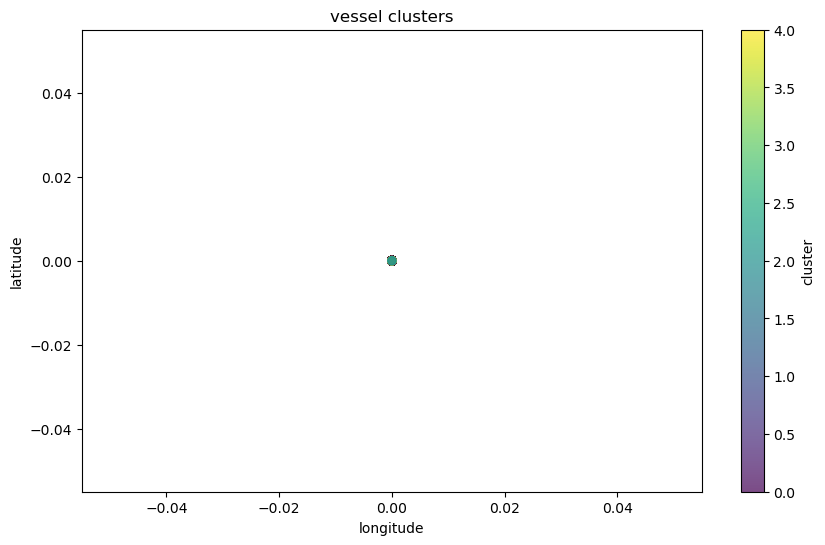

clustered dataframe saved to 'clustered_vessel_data.csv'
       imo       mmsi     vessel_name             date_of_build    vesseltype  \
1  9984730  636023994  SEACON ANTWERP  2024-06-06T00:00:00.000Z  Bulk Carrier   
2  9984730  636023994  SEACON ANTWERP  2024-06-06T00:00:00.000Z  Bulk Carrier   
3  9984730  636023994  SEACON ANTWERP  2024-06-06T00:00:00.000Z  Bulk Carrier   
4  9984730  636023994  SEACON ANTWERP  2024-06-06T00:00:00.000Z  Bulk Carrier   
5  9984730  636023994  SEACON ANTWERP  2024-06-06T00:00:00.000Z  Bulk Carrier   

          group                 timestamp         lon       lat  nav_stat  \
1  Bulk Carrier 2024-07-28 00:25:02+00:00  104.029755  1.285643         0   
2  Bulk Carrier 2024-07-28 00:30:01+00:00  104.029420  1.291690         0   
3  Bulk Carrier 2024-07-28 00:32:51+00:00  104.028160  1.294758         0   
4  Bulk Carrier 2024-07-28 00:35:02+00:00  104.026474  1.296387         0   
5  Bulk Carrier 2024-07-28 00:35:52+00:00  104.025780  1.296852        

In [53]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# load ais dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# preprocess the dataset
def preprocess_data(data):
    # dynamically handle timestamp column
    timestamp_col = next((col for col in data.columns if 'timestamp' in col.lower()), None)
    if timestamp_col:
        data['timestamp'] = pd.to_datetime(data[timestamp_col], errors='coerce')
    else:
        print("Warning: No timestamp column found. Creating a dummy timestamp column.")
        data['timestamp'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(range(len(data)), unit='s')

    # dynamically handle latitude, longitude, speed, and vessel type column names
    column_mappings = {
        'latitude': next((col for col in data.columns if 'latitude' in col.lower()), None),
        'longitude': next((col for col in data.columns if 'longitude' in col.lower()), None),
        'speed': next((col for col in data.columns if 'speed' in col.lower()), None),
        'vesseltype': next((col for col in data.columns if 'vesseltype' in col.lower() or 'vessel_type' in col.lower()), None)
    }

    # check for missing required columns
    missing_columns = [key for key, value in column_mappings.items() if value is None]
    if missing_columns:
        print("Warning: Missing required columns. Adding placeholders.")
        for col in missing_columns:
            if col == 'latitude' or col == 'longitude':
                data[col] = 0  # Default to 0 for missing latitude/longitude
            elif col == 'speed':
                data[col] = 0  # Default speed to 0
            elif col == 'vesseltype':
                data[col] = 'Unknown'  # Default vessel type to 'Unknown'

    # rename columns to standard names for consistency
    data.rename(columns={value: key for key, value in column_mappings.items() if value}, inplace=True)

    # drop rows with missing or invalid values
    data.dropna(subset=['latitude', 'longitude', 'speed', 'vesseltype'], inplace=True)

    return data.copy()

# extract relevant features for clustering
def extract_features(data):
    # select numerical features for clustering
    features = data[['latitude', 'longitude', 'speed']].copy()
    return features

# perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # add cluster labels to the dataset
    features['cluster'] = clusters
    return features, kmeans

# plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['longitude'], features['latitude'], c=features['cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='cluster')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('vessel clusters')
    plt.show()

# main function to return clustered dataframe
def main(file_path):
    # step 1: load data
    data = load_data(file_path)

    # step 2: preprocess data
    data = preprocess_data(data)

    # step 3: extract features for clustering
    features = extract_features(data)

    # step 4: perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # step 5: add cluster labels back to original data
    data['cluster'] = clustered_features['cluster'].values

    # step 6: visualize clusters
    plot_clusters(clustered_features)

    # step 7: save and return the clustered dataframe
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("clustered dataframe saved to 'clustered_vessel_data.csv'")

    return data

# run the function to get the clustered dataframe
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# print a sample of the clustered dataframe
print(clustered_df.head())
